<a href="https://colab.research.google.com/github/willyptrain/cs4774-mask-detection/blob/main/wider_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab stuff
# from google.colab import drive
# drive.mount("/content/drive/")


# !unzip 'drive/My Drive/wider_face_split' 
# !unzip 'drive/My Drive/WIDER_train' 
# !unzip 'drive/My Drive/WIDER_val' 
# !unzip 'drive/My Drive/WIDER_test'


# train_images = np.load("WIDER_train_images.npy")
# print(train_images.shape)

# np.savez_compressed("wider_train_compressed", train_images)

# val_images = np.load("WIDER_val_images.npy")
# np.savez_compressed("wider_val_compressed", val_images)
# print(val_images.shape)

# !cp "/content/wider_train_compressed.npz" "/content/drive/My Drive/wider_train_compressed.npz"
# !cp "/content/wider_val_compressed.npz" "/content/drive/My Drive/wider_val_compressed.npz"





In [ ]:


# Machine Learning Homework 4 - Image Classification

__author__ = 'wcp7cp'

# General imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import os
import sys
import pandas as pd

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

import scipy.io as sio
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2


In [2]:

def load_and_write_data(folder, save=True):
  x = np.array([])
  y = []
  index = 0
  img_paths = []
  for subfolder in os.listdir('/content/'+folder+'/images'):
      for path in os.listdir('/content/'+folder+'/images/'+subfolder):
        img_path = '/content/'+folder+'/images/' + subfolder + "/" + path
        img_paths.append(img_path)
        # img = cv2.resize(cv2.imread(img_path), (320,320))
        # if(index == 0):
        #   x = np.array([img])
        # else:
        #   x = np.append(x, [img], axis=0)
        index += 1
        print(index)
  print(x.shape)
  if(save):
    np.save('/content/'+folder+"_images.npy", x)
  return img_paths 


train_paths = load_and_write_data("WIDER_train", save=False)
val_paths = load_and_write_data("WIDER_val", save=False)

# with open('/content/drive/My Drive/train_img_paths.txt','w') as f:
#   for path in train_paths:
#     f.write(path+"\n")

# with open('/content/drive/My Drive/val_img_paths.txt','w') as f:
#   for path in val_paths:
#     f.write(path+"\n")


In [ ]:
train_img_paths = []
val_img_paths = []

with open('/content/drive/My Drive/train_img_paths.txt','r') as f:
  for line in f:
    train_img_paths.append(line.rstrip("\n"))
    

with open('/content/drive/My Drive/val_img_paths.txt','r') as f2:
    for line in f2:
      val_img_paths.append(line.rstrip("\n"))

print(len(train_img_paths))
print(len(val_img_paths))

12880
3226


In [ ]:
# import glob

# def load_mat(filename, folder):
#   count = 0
#   mat_contents = sio.loadmat(filename)
#   bbox = {}
#   bbox_y = []
#   sizes = {}
#   for i in range(0, len(mat_contents['file_list'])):
#     print(i)
#     for c in range(0, len(mat_contents['file_list'][i])):
#       for y in range(0, len(mat_contents['file_list'][i][c])):
#         image_file = mat_contents['file_list'][i][c][y][0][0]
#         count += 1
#         bbox[image_file] = mat_contents['face_bbx_list'][i][c][y]
#         bbox_y.append(mat_contents['face_bbx_list'][i][c][y])
#         folder_prefix = image_file.split("_")[0]
#         img_path = glob.glob(folder + folder_prefix+'--*', recursive=True)[0] + "/"
#         img = cv2.imread(img_path+image_file+".jpg")
#         h, w, dim = img.shape
#         sizes[image_file] = {"h": h, "w": w, "dim": dim}
#         mat_contents['face_bbx_list'][i][c][y][0] = mat_contents['face_bbx_list'][i][c][y][0] / [w, h, h, w]
#         # mat_contents['face_bbx_list'][i][c][y][0][:,1] /= h
#         # mat_contents['face_bbx_list'][i][c][y][0][:,2] /= h
#         # mat_contents['face_bbx_list'][i][c][y][0][:,3] /= w

#   return bbox, bbox_y, sizes
      
# train_file = "wider_face_split/wider_face_train.mat"
# val_file = "wider_face_split/wider_face_val.mat"
# test_file = "wider_face_split/wider_face_test.mat"

# train_boxes, train_y, sizes_train = load_mat(train_file, folder="/content/WIDER_train/images/")
# val_boxes, val_y, sizes_val = load_mat(val_file, folder="/content/WIDER_val/images/")


In [3]:
import glob


def load_mat(filename, folder):
  count = 0
  mat_contents = sio.loadmat(filename)
  bbox = {}
  bbox_y = []
  sizes = {}
  for i in range(0, len(mat_contents['file_list'])):
    print(i)
    for c in range(0, len(mat_contents['file_list'][i])):
      for y in range(0, len(mat_contents['file_list'][i][c])):
        image_file = mat_contents['file_list'][i][c][y][0][0]
        count += 1
        # bbox[image_file] = mat_contents['face_bbx_list'][i][c][y]
        folder_prefix = image_file.split("_")[0]
        img_path = glob.glob(folder + folder_prefix+'--*', recursive=True)[0] + "/"
        img = cv2.imread(img_path+image_file+".jpg")
        h, w, dim = img.shape
        sizes[image_file] = {"h": h, "w": w, "dim": dim}
        # print(image_file,mat_contents['face_bbx_list'][i][c][y][0][:,2])
        # mat_contents['face_bbx_list'][i][c][y][0][:,2] = mat_contents['face_bbx_list'][i][c][y][0][:,0] + mat_contents['face_bbx_list'][i][c][y][0][:,2]
        # mat_contents['face_bbx_list'][i][c][y][0][:,3] = mat_contents['face_bbx_list'][i][c][y][0][:,1] + mat_contents['face_bbx_list'][i][c][y][0][:,3]
        mat_contents['face_bbx_list'][i][c][y][0] = mat_contents['face_bbx_list'][i][c][y][0] / [w, h, h, w]
        bbox[image_file] = mat_contents['face_bbx_list'][i][c][y]


  return bbox, sizes
      
train_file = "wider_face_split/wider_face_train.mat"
val_file = "wider_face_split/wider_face_val.mat"
test_file = "wider_face_split/wider_face_test.mat"

train_boxes, sizes_train = load_mat(train_file, folder="/content/WIDER_train/images/")
val_boxes, sizes_val = load_mat(val_file, folder="/content/WIDER_val/images/")



  


In [ ]:
y_train = []
y_val = []
index = 0
with open('/content/drive/My Drive/train_annotations.txt','w') as f:
  for path in train_img_paths:
    folder_img_path = "./" + "/".join(path.split("/")[1:])
    img_path = path.split("/")[-1].rstrip(".jpg")
    string_form = " ".join([(",".join(map(str,box)) + ",0") for box in list(train_boxes[img_path][0])])
    # if(string_form != "0,0,0,0,0"):
      # index += 1
      # print(index)
      # f.write(folder_img_path + " " + string_form + "\n")
    y_train.append(train_boxes[img_path])
    
    
f.close()    

index = 0
with open('/content/drive/My Drive/val_annotations.txt','w') as f:
  for path in val_img_paths:
    folder_img_path = "./" + "/".join(path.split("/")[1:])
    img_path = path.split("/")[-1].rstrip(".jpg")
    string_form = " ".join([(",".join(map(str,box)) + ",0") for box in list(val_boxes[img_path][0])])
    # if(string_form != "0,0,0,0,0"):
      # index += 1
      # print(index)
      # f.write(folder_img_path + " " + string_form + "\n")
    
    y_val.append(val_boxes[img_path])
    
f.close()

y_train = np.array(y_train)
y_val = np.array(y_val)

print(y_train.shape, y_val.shape)





(12880, 1) (3226, 1)


In [ ]:
train_images = None
val_images = None

with np.load("/content/drive/My Drive/wider_val_compressed.npz") as f:
  val_images = f['arr_0']

print(val_images.shape)

with np.load("/content/drive/My Drive/wider_train_compressed.npz") as f:
  train_images = f['arr_0']


print(train_images.shape)



(3226, 320, 320, 3)
(12880, 320, 320, 3)


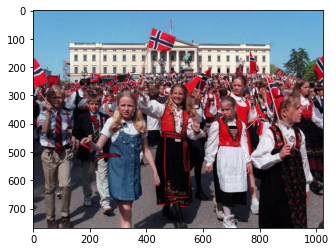

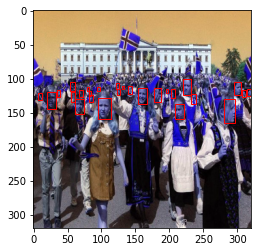

In [ ]:

index = 1
test_file = train_img_paths[index]
parse_name = test_file.split("/")[-1].rstrip(".jpg")
im = np.array(Image.open(test_file), dtype=np.uint8)

fig,ax = plt.subplots(1)
ax.imshow(im)

for c in range(0, len(train_boxes[parse_name][0])):
  shape_vec = [sizes_train[parse_name]['w'], sizes_train[parse_name]['h'], sizes_train[parse_name]['h'], sizes_train[parse_name]['w']]
  # xmin, ymin, height, width = train_boxes[parse_name][0][c] * shape_vec
  xmin, ymin, xmax, ymax = train_boxes[parse_name][0][c]
  rect = patches.Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

plt.show()


numpy_im = train_images[index]

fig,ax = plt.subplots(1)
ax.imshow(numpy_im)

for c in range(0, len(train_boxes[parse_name][0])):
  
  ratio = sizes_train[parse_name]['w'] / sizes_train[parse_name]['h']
  shape_vec = [320, 320, 320/ratio, 320*ratio]
  xmin, ymin, height, width = train_boxes[parse_name][0][c] * shape_vec
  rect = patches.Rectangle((xmin,ymin),height,width,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  # xmin, ymin, xmax, ymax = train_boxes[parse_name][0][c]
  # xmin = (xmin - x1) * IMG_SIZE / (x2 - x1)
  # xmax = xmax / (320*ratio)
  # ymin = ymin / (320*ratio)
  # ymax = ymax / (320*ratio)
  # print(xmin, ymin, xmax, ymax)
  # rect = patches.Rectangle((xmin,ymin),(ymax - ymin),(xmax - xmin),linewidth=1,edgecolor='r',facecolor='none')
  

plt.show()


In [ ]:
# !wget "https://pjreddie.com/media/files/yolov3.weights"
# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

In [ ]:
# !git clone https://github.com/david8862/keras-YOLOv3-model-set.git
# print(os.getcwd())
yolo_weights = "/content/drive/My Drive/yolov3.weights"
yolo_cfg = "/content/drive/My Drive/yolov3.cfg"
net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
ln = net.getLayerNames()
print(len(ln), ln)

254 ['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38',

In [ ]:
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

['yolo_82', 'yolo_94', 'yolo_106']


person 0.9996263
-6 24 351 377


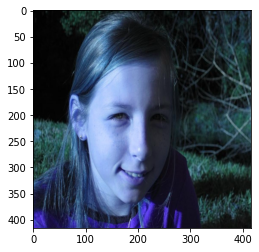

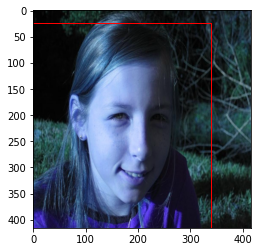

In [ ]:
img = cv2.resize(cv2.imread(train_paths[3]), (416,416))
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=True)
r = blob[0, 0, :, :]

net.setInput(blob)
outputs = net.forward(ln)
plt.imshow(img)

#ADAPTED FROM: https://colab.research.google.com/drive/1dYwDAjSgzj_9MQEZ4Uu3nR_9K-4zlsqQ#scrollTo=Bn95xJWPL63i
def yolo(img):
    coco = "/content/coco.names"
    LABELS = open(coco).read().strip().split("\n")
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
        swapRB=True, crop=True)
    net.setInput(blob)
    layerOutputs = net.forward(ln)


    h_img = img.shape[0]
    w_img = img.shape[1]

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > .5:
                print(LABELS[classID], confidence)
   
                box = detection[0:4] * np.array([w_img, h_img, w_img, h_img])
                (centerX, centerY, w, h) = box.astype("int")

                x = int(centerX - (w / 2))
                y = int(centerY - (h / 2))

                print(x, y, int(w), int(h))
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, .5, .4 )
    if len(idxs) > 0:
        fig,ax = plt.subplots(1)
        ax.imshow(img)
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            rect = patches.Rectangle((x,y),x+w,y+h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
        plt.show()

yolo(img)

In [ ]:
wider_yolo_config = "/content/drive/My Drive/wider_face_yolov3.cfg"